In [8]:
# uncomment code if running the script on google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import torch
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

plt.rcParams['font.size'] = '16'

# Checking if CUDA is available
flag_cuda = torch.cuda.is_available()

if not flag_cuda:
    print('Using CPU')
else:
    print('Using GPU')

Using CPU


In [23]:
# set training and test dataset sources path
fromPath = '/content/drive/MyDrive/ECE542_fa2021_Project_TerrainRecognition/TrainingData/' # change this path to the folder where training data (.csv) files are available
toPath = '/content/drive/MyDrive/Colab Notebooks/projC phase II/code/' # this is path where results are saved. (default path- current folder)

#### Helper functions and class

In [24]:
### Helper functions
def getSubjectId(path):
  lstFile = []
  for f in os.listdir(path):
    if re.search(".*_x_time.csv", f, re.I):
      lstFile.append((f.split('_')[1], f.split('_')[2]))
  return lstFile


def generate_target(x, x_size):
  tg = []
  for t in x:
    if t == 0:
      [tg.append(0) for i in range(0,4)]
    elif t == 1:
      [tg.append(1) for i in range(0,4)]
    elif t == 2:
      [tg.append(2) for i in range(0,4)]
    else:
      [tg.append(3) for i in range(0,4)]

  if len(tg) >= x_size:
    return tg[:x_size]
  else:
    tg.append(tg[-1])
    return tg

def combineSubjectData(train_path_r = '/', train_path_w = '/'):
  cols = ['xA','yA','zA', 'xG','yG','zG']
  trainingSubjects = getSubjectId(train_path_r)

  # preparating training data
  df = pd.DataFrame()
  train_df = pd.DataFrame()

  for s,r in trainingSubjects:
    x_df = pd.read_csv(os.path.join(train_path_r,'subject_{}_{}__x.csv'.format(s,r)),header =None)
    x_time_df = pd.read_csv(os.path.join(train_path_r,'subject_{}_{}__x_time.csv'.format(s,r)), header = None)
    y_df = pd.read_csv(os.path.join(train_path_r,'subject_{}_{}__y.csv'.format(s,r)), header = None)
    x_df.columns = cols
    x_time_df.columns = ['time']
    y_df.columns = ['target']
    target = generate_target(y_df['target'], x_time_df.shape[0])

    ## merge
    x_df = x_time_df.merge(x_df, left_index=True,right_index=True)
    x_df['y'] = target

    train_df = pd.concat([train_df, x_df], axis = 0)

  # writing to the given path
  train_df.to_csv(train_path_w+'raw_train_data_all_Subjects.csv', index = False)



# Custom Class to load data from local system to Pytorch model
class LoadTerrainDataSet(Dataset):
  def __init__(self, path, transform , IsTrain = True,):
    self.path = path
    self.sample = []
    self.label = []
    self.IsTrain = IsTrain
    self.transform = transform

    if self.IsTrain:
      train_data = pd.read_csv(self.path+'raw_train_data_all_Subjects.csv')
      noOfCols = train_data.shape[1]
      noOfRows = train_data.shape[0]
      train_X = train_data.loc[:,['xA','yA','zA','xG','yG','zG']]
      train_y = train_data.loc[:,'y']

      start_index = 1
      end_index = 48
      image_height = 48
      for indx in range(1,noOfRows-image_height):
        start_index = indx
        self.sample.append(train_X[start_index:end_index+1].values)
        self.label.append(train_y[end_index]) 
        end_index += 1

  def __len__(self):
    return len(self.sample)

  def __getitem__(self, index):
    X,y = self.sample[index], self.label[index]
    r,c = X.shape
    X = self.transform(torch.from_numpy(X.reshape((1,r,c))))
    y = torch.from_numpy(np.asarray(y))
    return X,y

### Preparing training data before model training

In [26]:
# set seed to replicate the results
torch.manual_seed(0)

# set batch size and number of iterations
batch_size  = 5000
n_epochs = 40

# Convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Normalize((0.5), (0.5))
    ])

# combining training data
combineSubjectData(fromPath, toPath)

# Read 2-Dimentional data as an image of size 48 X 6
data = LoadTerrainDataSet(toPath, transform)

# Percentage of training used for validation
train_set_len = int(len(data)*0.7)+1
valid_set_len = int(len(data)*0.3)

# Split total data into training and validation datasets
train_set, validation_set = torch.utils.data.random_split(data, [train_set_len, valid_set_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)

# State all the classes
classes = ['0','1','2','3']

In [28]:
# Defining the CNN architecture
class TerrainClassifier(nn.Module):
  def __init__(self):
    super(TerrainClassifier, self).__init__()
    self.conv1 = nn.Conv2d(1,5,3,1,1)
    self.batch1 = nn.BatchNorm2d(5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(5, 4, 3,1,1)
    self.batch2 = nn.BatchNorm2d(4)
    self.fc1 = nn.Linear(4 * 48 * 6,  30)
    self.batch3 = nn.BatchNorm1d(30)
    self.fc2 = nn.Linear(30, 16)
    self.batch4 = nn.BatchNorm1d(16)
    self.fc3 = nn.Linear(16, 4)

  def forward(self, x):
    x = F.relu(self.batch1(self.conv1(x)))
    x = F.relu(self.batch2(self.conv2(x)))
    x = x.view(-1, 4*48*6) 
    x = F.relu(self.batch3(self.fc1(x)))
    x = F.relu(self.batch4(self.fc2(x)))
    x = self.fc3(x)
    return x

# Create a complete CNN
model = TerrainClassifier()
print(model)

# Move tensors to GPU if CUDA is available
if flag_cuda:
  model.cuda()

# Specifying the loss function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters())

TerrainClassifier(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1152, out_features=30, bias=True)
  (batch3): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=30, out_features=16, bias=True)
  (batch4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=16, out_features=4, bias=True)
)


In [29]:
# Define function to compute running accuracy
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

def trainTerraceClassifier(model,criterion,optimizer,n_epochs,flag_cuda):
  # Number of epochs to train the model
  epochs_list = [*range(1,n_epochs+1)]

  # List to store loss to visualize
  train_losslist = []
  valid_losslist = []
  valid_loss_min = np.Inf 
  train_running_accuracy = []
  val_running_Accuracy = []

  for epoch in epochs_list:
      # Keeping track of training and validation loss
      train_loss = 0.0
      valid_loss = 0.0
      train_acc = 0.0
      val_acc = 0.0
      
      #################################
      # Training the classifier model #
      #################################
      model.train()
      for data, target in train_loader:
          # Moving tensors to GPU if CUDA is available
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          # Clearing the gradients of all optimized variables
          optimizer.zero_grad()
          # Forward pass: Computing predicted outputs
          output = model(data.float())
          # Calculating the batch loss
          loss = criterion(output, target)
          # Backward pass: compute gradient of loss with respect to parameters
          loss.backward()
          # Perform a single optimization step (parameter update)
          optimizer.step()
          # Update training loss
          train_loss += loss.item()*data.size(0)
          train_acc += accuracy(output, target) 

          
      ###################################    
      # Validating the classifier model #
      ##################################
      model.eval()
      for data, target in validation_loader:
          # Moving tensors to GPU if CUDA is available
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          output = model(data.float())
          loss = criterion(output, target)
          valid_loss += loss.item()*data.size(0)
          val_acc += accuracy(output, target)
      
      # Calculating average losses
      train_loss /= train_set_len
      valid_loss /= valid_set_len
      train_acc /= len(train_loader)
      val_acc /= len(validation_loader)
      train_losslist.append(train_loss)
      valid_losslist.append(valid_loss)
      val_running_Accuracy.append(val_acc)
      train_running_accuracy.append(train_acc)

          
      # Printing training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      
      # Saving model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,valid_loss))
          torch.save(model.state_dict(), toPath+'/model_cifar.pt')
          valid_loss_min = valid_loss
        
  return epochs_list, train_losslist, valid_losslist, train_running_accuracy, val_running_Accuracy

# Executing the training
epochs_list, train_losslist, valid_losslist, train_acclist, valid_acclist = trainTerraceClassifier(
    model,criterion,optimizer,n_epochs,flag_cuda)



Epoch: 1 	Training Loss: 0.709681 	Validation Loss: 0.367280
Validation loss decreased (inf --> 0.367280).  Saving model ...
Epoch: 2 	Training Loss: 0.260581 	Validation Loss: 0.225777
Validation loss decreased (0.367280 --> 0.225777).  Saving model ...
Epoch: 3 	Training Loss: 0.198847 	Validation Loss: 0.199429
Validation loss decreased (0.225777 --> 0.199429).  Saving model ...
Epoch: 4 	Training Loss: 0.176433 	Validation Loss: 0.176987
Validation loss decreased (0.199429 --> 0.176987).  Saving model ...
Epoch: 5 	Training Loss: 0.164627 	Validation Loss: 0.172515
Validation loss decreased (0.176987 --> 0.172515).  Saving model ...
Epoch: 6 	Training Loss: 0.156739 	Validation Loss: 0.164343
Validation loss decreased (0.172515 --> 0.164343).  Saving model ...
Epoch: 7 	Training Loss: 0.151177 	Validation Loss: 0.163543
Validation loss decreased (0.164343 --> 0.163543).  Saving model ...
Epoch: 8 	Training Loss: 0.146545 	Validation Loss: 0.160408
Validation loss decreased (0.16354

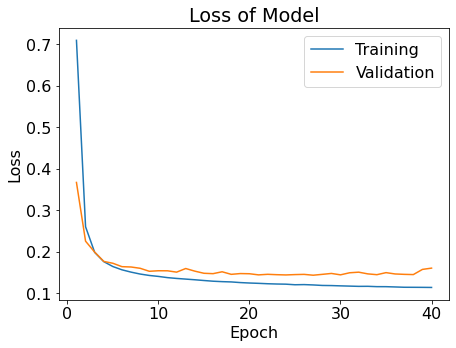

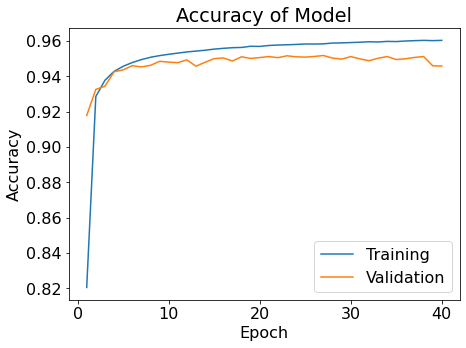

In [39]:
# Loading the best model
model.load_state_dict(torch.load(toPath+'/model_cifar.pt'))

# Plotting the learning curves
fig, ax  = plt.subplots(1,1, figsize = (7,5))
ax.plot(epochs_list, train_losslist, epochs_list, valid_losslist)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(['Training','Validation'])
ax.set_title("Loss of Model")
plt.show()
fig.savefig(os.path.join(toPath,'loss.png'), dpi = 300)


fig, ax  = plt.subplots(1,1, figsize = (7,5),)
ax.plot(epochs_list, train_acclist, epochs_list, valid_acclist)
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(['Training','Validation'])
ax.set_title("Accuracy of Model")
plt.show()
fig.savefig(os.path.join(toPath,'accuracy.png'), dpi = 300)

In [40]:
def assessClassifier(model,criterion):
  # Tracking test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))
  actual_class = []
  predicted_class = []

  # Setting model to evaluate
  model.eval()

  # Iterating over batches of test data
  for data, target in validation_loader:
      # Obtaining predictions and loss
      if flag_cuda:
          data, target = data.cuda(), target.cuda()
      output = model(data.float())
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

      # Converting output probabilities to predicted class
      _, pred = torch.max(output, 1) 
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not flag_cuda else np.squeeze(correct_tensor.cpu().numpy())

      # Calculating test accuracy for each object class
      for i in range(len(data)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  # Computing the average test loss
  test_loss = test_loss/len(validation_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  # Computing the class accuracies
  for i in range(4):
      if class_total[i] > 0:
          print('Test Accuracy of %10s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %10s: N/A (no training examples)' % (classes[i]))

  # Computing the overall accuracy
  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))
  
assessClassifier(model,criterion)

Test Loss: 0.143746

Test Accuracy of          0: 97% (294237/301932)
Test Accuracy of          1: 91% (15314/16683)
Test Accuracy of          2: 93% (20551/22073)
Test Accuracy of          3: 85% (52982/61791)

Test Accuracy (Overall): 95% (383084/402479)
